Example was taken from
https://unit8co.github.io/darts/examples/13-TFT-examples.html

In [ ]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [11]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"


Air Passenger

Ice Cream heater

(True, 12)
(True, 12)


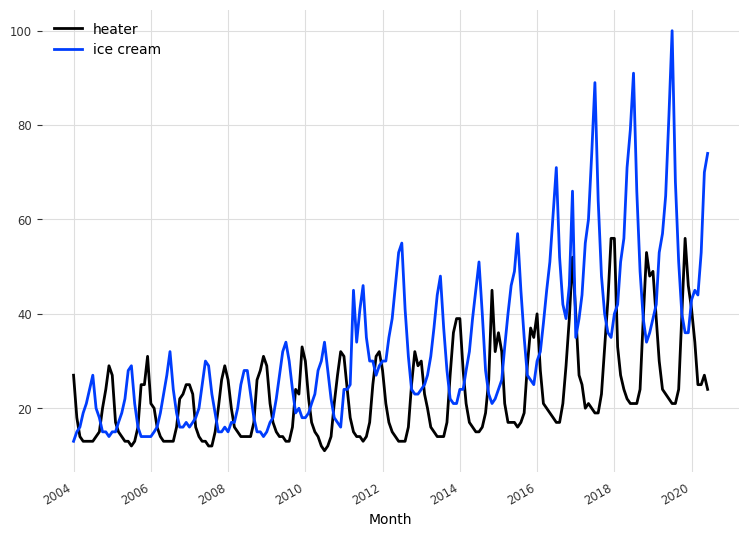

<Figure size 900x600 with 0 Axes>

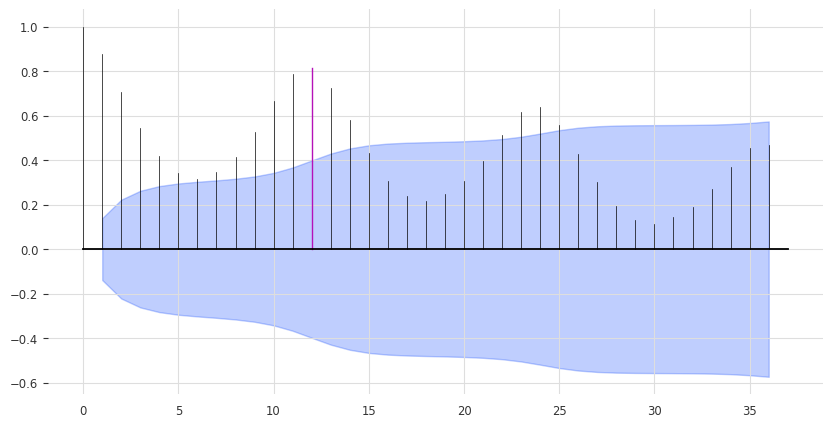

In [12]:
series_ice_heater = IceCreamHeaterDataset().load()

plt.figure(figsize=figsize)
series_ice_heater.plot()

print(check_seasonality(series_ice_heater["ice cream"], max_lag=36))
print(check_seasonality(series_ice_heater["heater"], max_lag=36))

plt.figure(figsize=figsize)
plot_acf(series_ice_heater["ice cream"], 12, max_lag=36)  # ~1 year seasonality

In [13]:
# convert monthly sales to average daily sales per month
converted_series = []
for col in ["ice cream", "heater"]:
    converted_series.append(
        series_ice_heater[col]
        / TimeSeries.from_series(series_ice_heater.time_index.days_in_month)
    )
converted_series = concatenate(converted_series, axis=1)
converted_series = converted_series[pd.Timestamp("20100101") :]

# define train/validation cutoff time
forecast_horizon_ice = 12
training_cutoff_ice = converted_series.time_index[-(2 * forecast_horizon_ice)]

# use ice cream sales as target, create train and validation sets and transform data
series_ice = converted_series["ice cream"]
train_ice, val_ice = series_ice.split_before(training_cutoff_ice)
transformer_ice = Scaler()
train_ice_transformed = transformer_ice.fit_transform(train_ice)
val_ice_transformed = transformer_ice.transform(val_ice)
series_ice_transformed = transformer_ice.transform(series_ice)

# use heater sales as past covariates and transform data
covariates_heat = converted_series["heater"]
cov_heat_train, cov_heat_val = covariates_heat.split_before(training_cutoff_ice)
transformer_heat = Scaler()
transformer_heat.fit(cov_heat_train)
covariates_heat_transformed = transformer_heat.transform(covariates_heat)

In [14]:
# use the last 3 years as past input data
input_chunk_length_ice = 36

# use `add_encoders` as we don't have future covariates
my_model_ice = TFTModel(
    input_chunk_length=input_chunk_length_ice,
    output_chunk_length=forecast_horizon_ice,
    hidden_size=32,
    lstm_layers=1,
    batch_size=16,
    n_epochs=300,
    dropout=0.1,
    add_encoders={"cyclic": {"future": ["month"]}}, #known future variable: month
    add_relative_index=False,
    optimizer_kwargs={"lr": 1e-3},
    random_state=42,
)

# fit the model with past covariates
my_model_ice.fit(
    train_ice_transformed, past_covariates=covariates_heat_transformed, verbose=True
)



Training: |          | 0/? [00:00<?, ?it/s]

TFTModel(hidden_size=32, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=36, output_chunk_length=12, batch_size=16, n_epochs=300, add_encoders={'cyclic': {'future': ['month']}}, optimizer_kwargs={'lr': 0.001}, random_state=42)

Predicting: |          | 0/? [00:00<?, ?it/s]

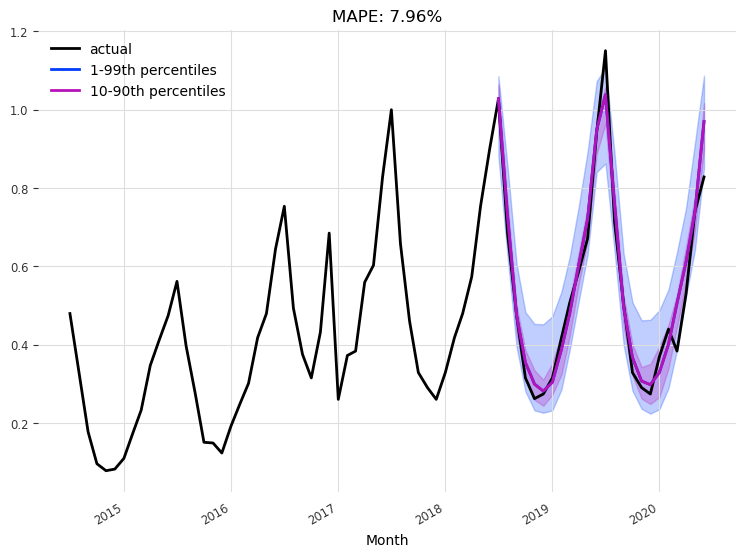

In [15]:
n = 24
eval_model(
    model=my_model_ice,
    n=n,
    actual_series=series_ice_transformed[
        train_ice.end_time() - (2 * n - 1) * train_ice.freq :
    ],
    val_series=val_ice_transformed,
)



In [16]:
# Compute the backtest predictions with the two models
last_points_only = False
backtest_series_ice = my_model_ice.historical_forecasts(
    series_ice_transformed,
    num_samples=num_samples,
    start=training_cutoff_ice,
    forecast_horizon=forecast_horizon_ice,
    stride=1 if last_points_only else forecast_horizon_ice,
    retrain=False,
    last_points_only=last_points_only,
    overlap_end=True,
    verbose=True,
)

backtest_series_ice = (
    concatenate(backtest_series_ice)
    if isinstance(backtest_series_ice, list)
    else backtest_series_ice
)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [18]:
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    plt.figure(figsize=figsize)
    actual_series.plot(label="actual")
    backtest_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    backtest_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(
                transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series),
            )
        )
    )

MAPE: 4.94%


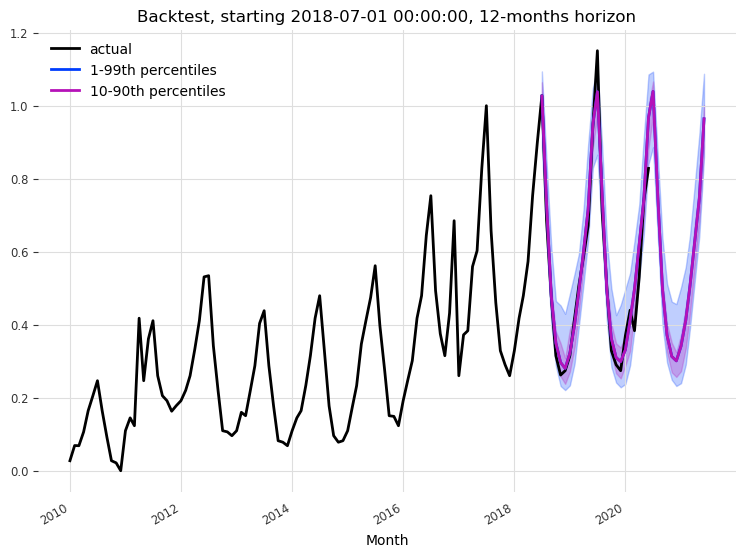

In [19]:
eval_backtest(
    backtest_series=backtest_series_ice,
    actual_series=series_ice_transformed[
        train_ice.start_time() - 2 * forecast_horizon_ice * train_ice.freq :
    ],
    horizon=forecast_horizon_ice,
    start=training_cutoff_ice,
    transformer=transformer_ice,
)

In [20]:
from darts.explainability import TFTExplainer
explainer = TFTExplainer(my_model_ice)
explainability_result = explainer.explain()


Predicting: |          | 0/? [00:00<?, ?it/s]

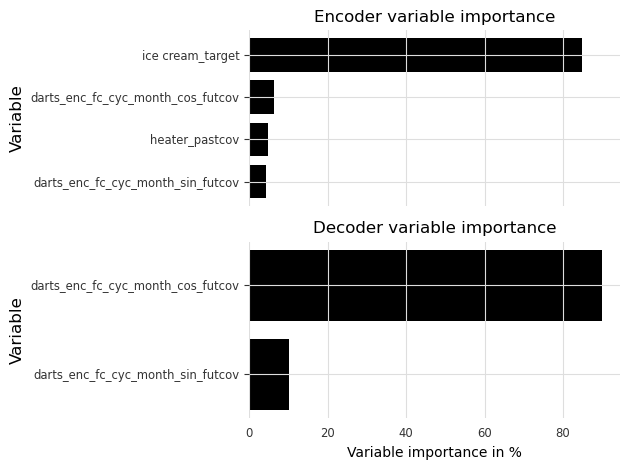

In [21]:
explainer.plot_variable_selection(explainability_result)

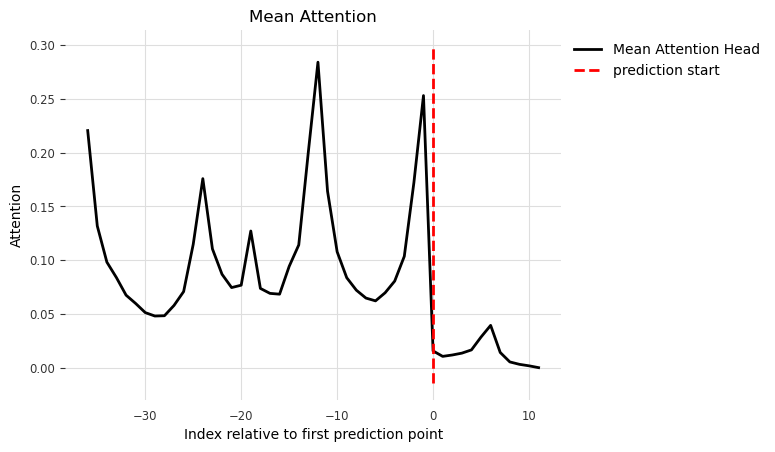

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [22]:
explainer.plot_attention(explainability_result, plot_type="time")

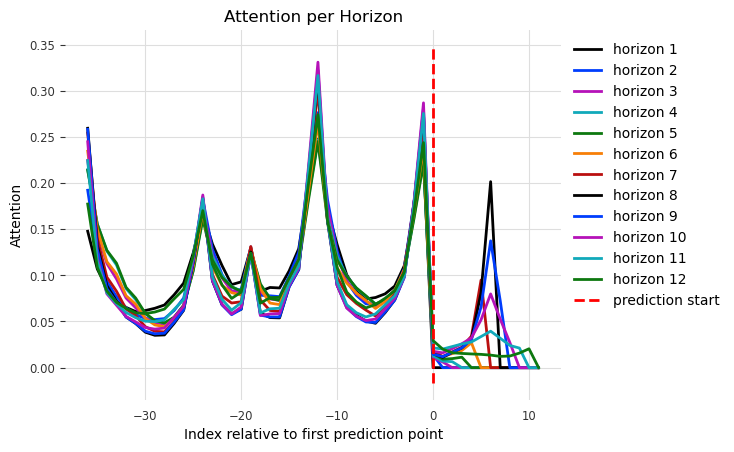

<Axes: title={'center': 'Attention per Horizon'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [23]:
explainer.plot_attention(explainability_result, plot_type="all")